# Bitcoin Price Forecasting using the Prophet Model

This notebook builds a complete **Bitcoin (BTC-USD) price forecasting pipeline** using the **Prophet** model.

We will:

- Explore the historical BTC-USD daily data (non-stationarity, volatility).
- Prepare it for Prophet (log-transform, Prophet-friendly columns).
- Train a **baseline additive model**.
- Build an **improved multiplicative model with tuned changepoints**.
- Evaluate both models using **MAE, RMSE, MAPE** on an out-of-sample test set.
- Optionally perform **time-based cross-validation**.
- Connect practical results with Prophet theory:  
  \( y(t) = g(t) + s(t) + h(t) + \varepsilon_t \).


---

## 1. Import and Load the Bitcoin dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

from sklearn.metrics import mean_absolute_error, mean_squared_error

c:\Users\leoje\Desktop\Prophet_Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


#### Make plots

In [14]:
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] == (12, 5)

False

#### Ensure all columns are shown when printing DataFrames

In [15]:
pd.set_option("display.max_columns", None)

#### Load BTC-USD data

In [16]:
# 1. Load the raw CSV (no parse_dates yet)
df = pd.read_csv(r"BTC-USD.csv")

# Columns are currently ['Price', 'Close', 'High', 'Low', 'Open', 'Volume']
# The first column actually contains the dates, so rename it:
df = df.rename(columns={"Price": "Date"})

# 2. Convert the first column to datetime.
#    The rows "Ticker" and "Date" will become NaT and will be removed.
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# Keep only the rows where Date is a valid timestamp (i.e., drop "Ticker" & "Date")
df = df.dropna(subset=["Date"]).copy()

# 3. Make sure numeric columns are numbers
num_cols = ["Close", "High", "Low", "Open", "Volume"]
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")

# 4. Sort by date and set index
df = df.sort_values("Date").reset_index(drop=True)
df.set_index("Date", inplace=True)

print("Dataset shape:", df.shape)
display(df.head())

print("\nDataFrame info:")
display(df.info())

print("\nSummary statistics:")
display(df.describe())


Dataset shape: (2143, 5)


C:\Users\leoje\AppData\Local\Temp\ipykernel_38840\944294451.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"], errors="coerce")


,Close,High,Low,Open,Volume
Date,,,,,
2020-01-01,7200.174316,7254.330566,7174.944336,7194.892090,18565664997
2020-01-02,6985.470215,7212.155273,6935.270020,7202.551270,20802083465
2020-01-03,7344.884277,7413.715332,6914.996094,6984.428711,28111481032
2020-01-04,7410.656738,7427.385742,7309.514160,7345.375488,18444271275
2020-01-05,7411.317383,7544.497070,7400.535645,7410.451660,19725074095



DataFrame info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2143 entries, 2020-01-01 to 2025-11-12
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2143 non-null   float64
 1   High    2143 non-null   float64
 2   Low     2143 non-null   float64
 3   Open    2143 non-null   float64
 4   Volume  2143 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 100.5 KB


None


Summary statistics:


,Close,High,Low,Open,Volume
count,2143.000000,2143.000000,2143.000000,2143.000000,2.143000e+03
mean,46225.530281,47096.201219,45225.758697,46183.413244,3.600267e+10
std,31105.312029,31569.945721,30585.981010,31094.049111,2.127819e+10
min,4970.788086,5331.833984,4106.980957,5002.578125,5.331173e+09
25%,21596.555664,21884.274414,20997.401367,21561.271484,2.180296e+10
50%,39097.859375,39902.949219,37728.144531,38886.828125,3.163423e+10
75%,63186.886719,64373.062500,61734.574219,63168.056641,4.459778e+10
max,124752.531250,126198.070312,123196.046875,124752.140625,3.509679e+11


----

## 2. Exploratory Data Analysis (non-stationarity & volatility)

In this section we:

- Visualize the raw closing price.
- Compute basic statistics and apply a log-transform.
- Analyze **daily returns** and **rolling volatility** to highlight:
  - Non-stationarity of price levels.
  - Volatility clustering in returns (heteroskedasticity).

### 2.1 Plot the raw closing price

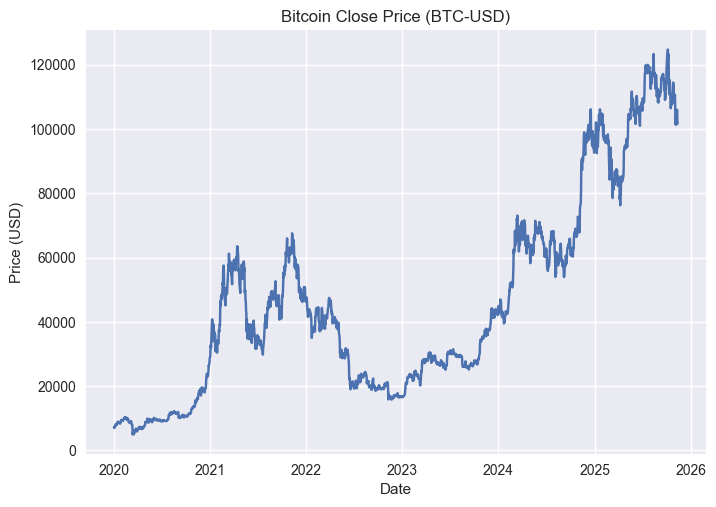

In [17]:
close = df["Close"].copy()

plt.figure()
plt.plot(close.index, close.values)
plt.title("Bitcoin Close Price (BTC-USD)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.show()

**Comment:**  
The Bitcoin closing price shows **strong non-stationarity** with clear **bubbles and crashes**.  
We see long bull markets followed by sharp drawdowns, which is typical for cryptocurrencies and makes classical linear time-series models challenging without transformations.

### 2.2 Basic statistics and log-transformation

Close price statistics:
min       4970.788086
max     124752.531250
mean     46225.530281
std      31105.312029
Name: Close, dtype: float64


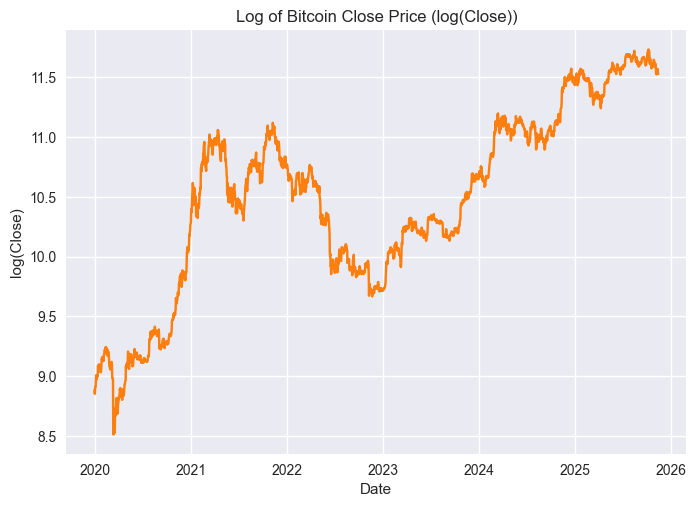

In [ ]:
# Basic statistics for the Close price
stats_close = close.agg(["min", "max", "mean", "std"])
print("Close price statistics:")
print(stats_close)

# Log-transform the Close price (we assume Close > 0)
df["log_close"] = np.log(df["Close"])

plt.figure()
plt.plot(df.index, df["log_close"], color="tab:orange")
plt.title("Log of Bitcoin Close Price (log(Close))")
plt.xlabel("Date")
plt.ylabel("log(Close)")
plt.grid(True)
plt.show()

**Why log-prices?**

In finance, we often work with **log-prices** because:

- They stabilize the variance when the series grows exponentially.
- Relative changes in price (multiplicative) become **additive** in log-space.
- Log-prices are more compatible with models assuming additive errors (like Prophet’s basic formulation).

### 2.3 Volatility analysis: daily returns and rolling volatility

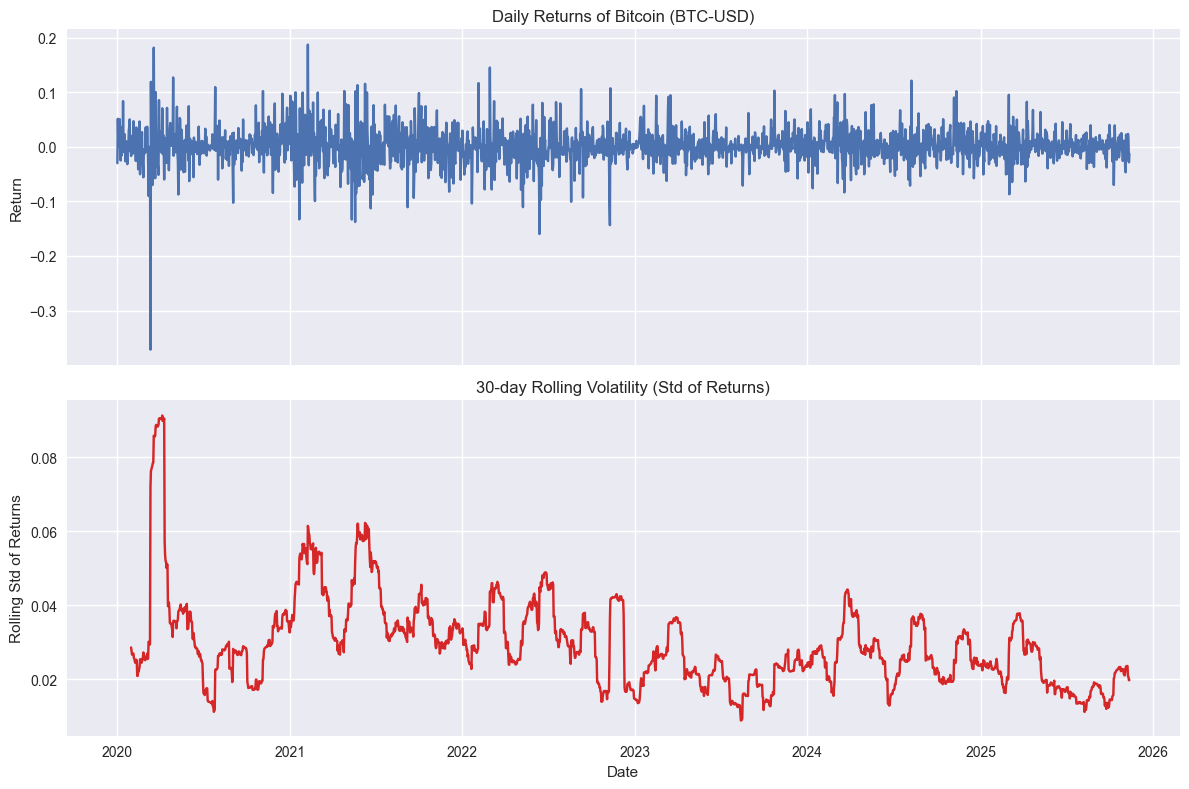

In [19]:
# Daily simple returns: r_t = Close_t / Close_{t-1} - 1
df["return"] = df["Close"].pct_change()

# 30-day rolling standard deviation of returns as a volatility proxy
rolling_window = 30
df["rolling_volatility"] = df["return"].rolling(window=rolling_window).std()

# Drop initial NaNs for clean plotting
returns = df["return"].dropna()
rolling_vol = df["rolling_volatility"].dropna()

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axes[0].plot(returns.index, returns.values)
axes[0].set_title("Daily Returns of Bitcoin (BTC-USD)")
axes[0].set_ylabel("Return")
axes[0].grid(True)

axes[1].plot(rolling_vol.index, rolling_vol.values, color="tab:red")
axes[1].set_title(f"{rolling_window}-day Rolling Volatility (Std of Returns)")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Rolling Std of Returns")
axes[1].grid(True)

plt.tight_layout()
plt.show()

**Interpretation:**

- **Returns** (rather than prices) look much more **stationary** around zero.
- Volatility is clearly **time-varying**:
  - Periods of calm (low volatility).
  - Periods of turbulence (volatility spikes and clusters).
- This is called **heteroskedasticity**.
  
Prophet primarily models the **conditional mean** (trend + seasonality).  
It does **not explicitly model volatility**.  
Thus, much of this time-varying volatility remains in the residual term \( \varepsilon_t \).

---

# 3. Data preparation for Prophet

Prophet expects a DataFrame with:

- Column `ds` : datestamps (datetime).
- Column `y`  : target variable.

We will:

- Use **log(Close)** as the target (`y`), to stabilize variance.
- Create a train/test split where the **last 365 days** are held out for evaluation.


### 3.1 Create Prophet dataframe (ds, y)

In [20]:
# Reset index to turn Date back into a column
df_reset = df.reset_index()

df_prophet = df_reset[["Date", "log_close"]].rename(
    columns={"Date": "ds", "log_close": "y"}
)

display(df_prophet.head())

,ds,y
0,2020-01-01,8.881861
1,2020-01-02,8.851588
2,2020-01-03,8.901759
3,2020-01-04,8.910674
4,2020-01-05,8.910763


We choose **log(Close)** as `y` because:

- Bitcoin prices span several orders of magnitude.
- Prophet is an **additive model** by default: \( y(t) = g(t) + s(t) + h(t) + \varepsilon_t \).
- Working in log-space makes additivity more compatible with the underlying multiplicative nature of financial growth.

In [43]:
# Build dataset with Typical Price instead of Close
df_model = df.copy()
df_model["Typical_Price"] = (df_model["High"] + df_model["Low"] + df_model["Close"]) / 3

df_prophet = df_model.reset_index()[["Date", "Typical_Price"]]
df_prophet = df_prophet.rename(columns={"Date": "ds", "Typical_Price": "y"})

# log-transform the typical price
df_prophet["y"] = np.log(df_prophet["y"])


### 3.2 Train/Test split (hold-out evaluation)

In [44]:
# We reserve the last 365 observations as the test set (≈ last year)
test_size = 365

# Ensure we have enough data
assert len(df_prophet) > test_size + 365, "Not enough data for a 365-day test set."

train = df_prophet.iloc[:-test_size].copy()
test = df_prophet.iloc[-test_size:].copy()

cutoff_date = train["ds"].max()

print(f"Number of observations: {len(df_prophet)}")
print(f"Train size: {len(train)}, Test size: {len(test)}")
print(f"Train/Test cutoff date: {cutoff_date.date()}")

Number of observations: 2143
Train size: 1778, Test size: 365
Train/Test cutoff date: 2024-11-12


We now have:

- **Training set**: from the beginning of the dataset (Start of 2020) up to **`cutoff_date`** (2024-11-12).  
- **Test set**: the last 365 days after this cutoff.

This mimics a realistic forecasting scenario where we train on the **past** and evaluate on **future data** that was not seen during training.

---

## 4. Baseline Prophet model (additive)

We start with a **baseline** Prophet configuration:

- **Trend**: piecewise linear (Prophet default), suitable for BTC without strict upper bound.
- **Seasonality**:
  - `weekly_seasonality=True`
  - `yearly_seasonality=True`
- **Seasonality mode**: `"additive"`.

We fit the model on the **training data only** and then forecast into the test period.


### 4.1 Baseline model definition and training

In [45]:
m_baseline = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    seasonality_mode="additive",  # baseline assumption
)

m_baseline.fit(train)

11:28:30 - cmdstanpy - INFO - Chain [1] start processing
11:28:30 - cmdstanpy - INFO - Chain [1] done processing


### 4.2 Forecast on the test period

In [46]:
# Extend the training dates by the length of the test set
future_baseline = m_baseline.make_future_dataframe(
    periods=len(test),
    freq="D"
)

forecast_baseline = m_baseline.predict(future_baseline)

# Keep useful columns
forecast_baseline = forecast_baseline[["ds", "yhat", "yhat_lower", "yhat_upper"]]

display(forecast_baseline.tail())

,ds,yhat,yhat_lower,yhat_upper
2138,2025-11-08,11.841942,8.931244,14.805907
2139,2025-11-09,11.840487,8.869424,14.766784
2140,2025-11-10,11.840370,8.885320,14.840621
2141,2025-11-11,11.840168,8.863557,14.787402
2142,2025-11-12,11.839632,8.865343,14.862359


In [47]:
# Helper function to merge actual & forecast and convert back to price level

def prepare_forecast_df(df_prophet_full, forecast_df):
    """
    Merge Prophet forecast with original data (log-price),
    and compute price-level actuals and predictions.
    """
    merged = df_prophet_full.merge(forecast_df, on="ds", how="left")
    
    # Actual price and predicted price (exp of log-values)
    merged["y_actual_price"] = np.exp(merged["y"])
    merged["yhat_price"] = np.exp(merged["yhat"])
    merged["yhat_lower_price"] = np.exp(merged["yhat_lower"])
    merged["yhat_upper_price"] = np.exp(merged["yhat_upper"])
    
    return merged

df_all_baseline = prepare_forecast_df(df_prophet, forecast_baseline)

# Show a few rows around the cutoff for sanity check
df_all_baseline[df_all_baseline["ds"].between(cutoff_date - pd.Timedelta(days=5),
                                              cutoff_date + pd.Timedelta(days=5))].head(10)


,ds,y,yhat,yhat_lower,yhat_upper,y_actual_price,yhat_price,yhat_lower_price,yhat_upper_price
1772,2024-11-07,11.235539,11.179658,11.079057,11.291510,75776.132812,71657.834007,64799.732252,80138.353856
1773,2024-11-08,11.244815,11.177113,11.078651,11.282542,76482.322917,71475.723857,64773.466656,79422.922101
1774,2024-11-09,11.244982,11.176183,11.074231,11.278874,76495.140625,71409.299368,64487.769878,79132.135428
1775,2024-11-10,11.283571,11.174581,11.075987,11.280849,79504.679688,71294.980379,64601.117237,79288.554054
1776,2024-11-11,11.364384,11.174408,11.069648,11.282800,86196.411458,71282.641237,64192.914623,79443.412643
1777,2024-11-12,11.381555,11.174241,11.073599,11.282579,87689.268229,71270.738169,64447.059017,79425.869914
1778,2024-11-13,11.408585,11.173823,11.066416,11.277193,90091.815104,71240.951726,63985.783094,78999.171613
1779,2024-11-14,11.391505,11.172093,11.060278,11.278368,88566.153646,71117.831948,63594.237834,79092.114370
1780,2024-11-15,11.407786,11.169744,11.062641,11.273963,90019.882812,70950.915430,63744.694867,78744.482282
1781,2024-11-16,11.416476,11.169456,11.058175,11.285554,90805.549479,70930.548216,63460.658308,79662.451221


### 4.3 Plot full forecast with changepoints

KeyError: 'trend'

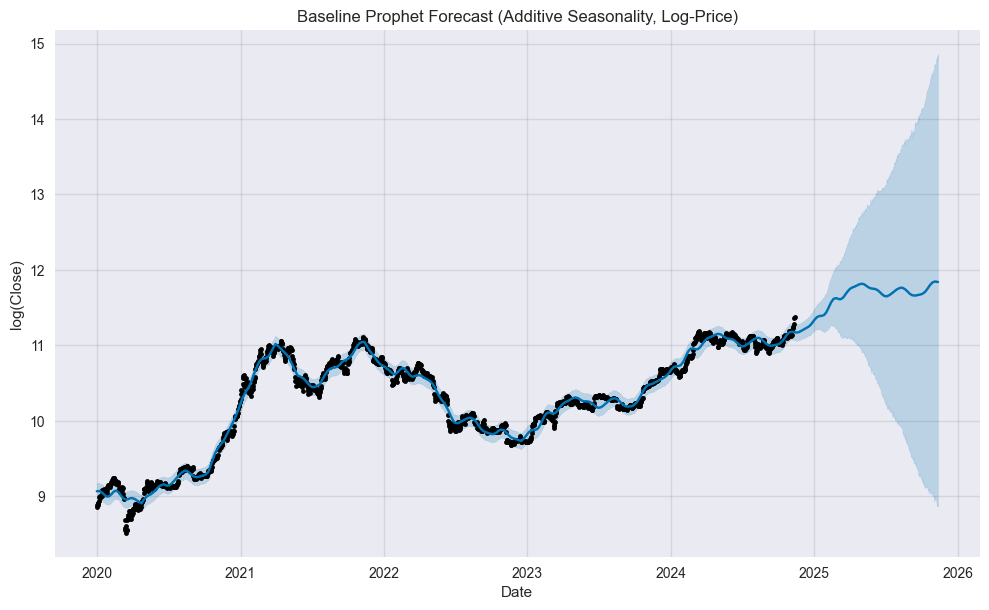

In [48]:
# 4.3 Plot full forecast with changepoints

fig1 = m_baseline.plot(forecast_baseline)
plt.title("Baseline Prophet Forecast (Additive Seasonality, Log-Price)")
plt.xlabel("Date")
plt.ylabel("log(Close)")
plt.grid(True)

# Add changepoints to the plot
_ = add_changepoints_to_plot(fig1.gca(), m_baseline, forecast_baseline)

plt.show()

# (déjà fait un peu plus haut mais ici on le refait pour que les components s'executent)
future_baseline = m_baseline.make_future_dataframe(
    periods=len(test),  
    freq="D"
)

# Forecast complet, avec 'trend', 'weekly', 'yearly', etc.
forecast_baseline_full = m_baseline.predict(future_baseline)

# Version light pour les métriques (optionnel)
forecast_baseline = forecast_baseline_full[["ds", "yhat", "yhat_lower", "yhat_upper"]].copy()


#### “full” forecast for the plot as the trendline shows a KeyError

In [49]:
# Future dataframe
future_baseline = m_baseline.make_future_dataframe(periods=365)

# Full forecast with all columns (ds, yhat, trend, components, etc.)
forecast_baseline_full = m_baseline.predict(future_baseline)

# Optional: lighter version for later metrics / export
forecast_baseline = forecast_baseline_full[["ds", "yhat", "yhat_lower", "yhat_upper"]].copy()


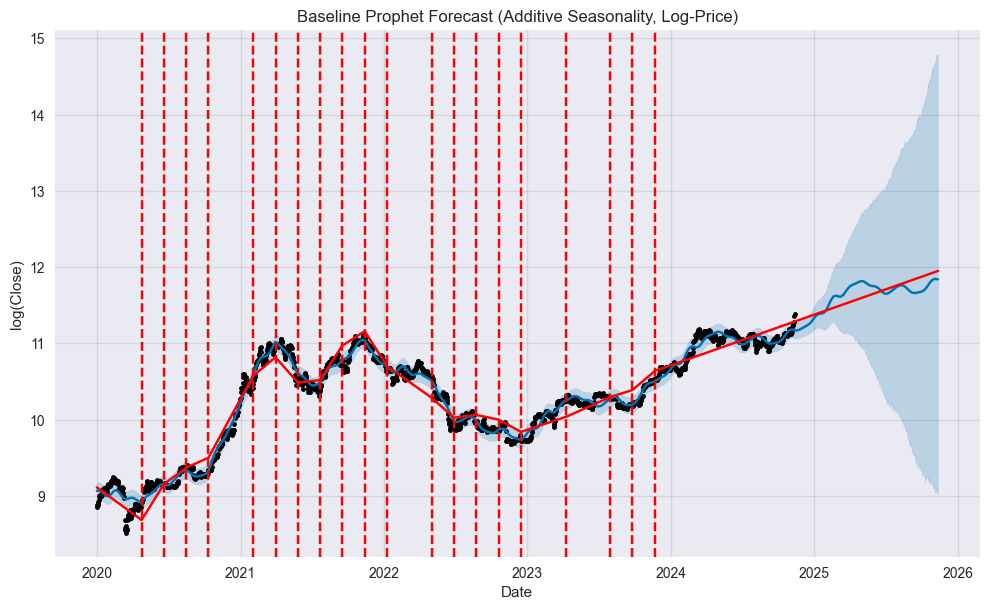

In [50]:
from prophet.plot import add_changepoints_to_plot

fig1 = m_baseline.plot(forecast_baseline_full)
plt.title("Baseline Prophet Forecast (Additive Seasonality, Log-Price)")
plt.xlabel("Date")
plt.ylabel("log(Close)")
plt.grid(True)

_ = add_changepoints_to_plot(fig1.gca(), m_baseline, forecast_baseline_full)

plt.show()


**Prophet decomposition reminder:**

Prophet models the time series as:

\[
y(t) = g(t) + s(t) + h(t) + \varepsilon_t
\]

- \( g(t) \): **trend** (here piecewise linear with automatic **changepoints**).  
- \( s(t) \): **seasonality** (weekly, yearly, etc.).  
- \( h(t) \): **holidays or special events** (not explicitly used here, but conceptually available).  
- \( \varepsilon_t \): **error term**, containing noise and unmodeled structure (including volatility).

On the plots above, vertical lines show **changepoints**, where Prophet adaptively changes the slope of the trend.  
For Bitcoin, these correspond to **regime shifts**: bull runs, crashes, regulatory events, etc.


---

## 5. Model diagnostics & components

We now inspect:

- The **trend and seasonality components** learned by the baseline model.
- The **residuals** on the training set, and how they relate to volatility.

### 5.1 Components plot: trend + weekly + yearly seasonality

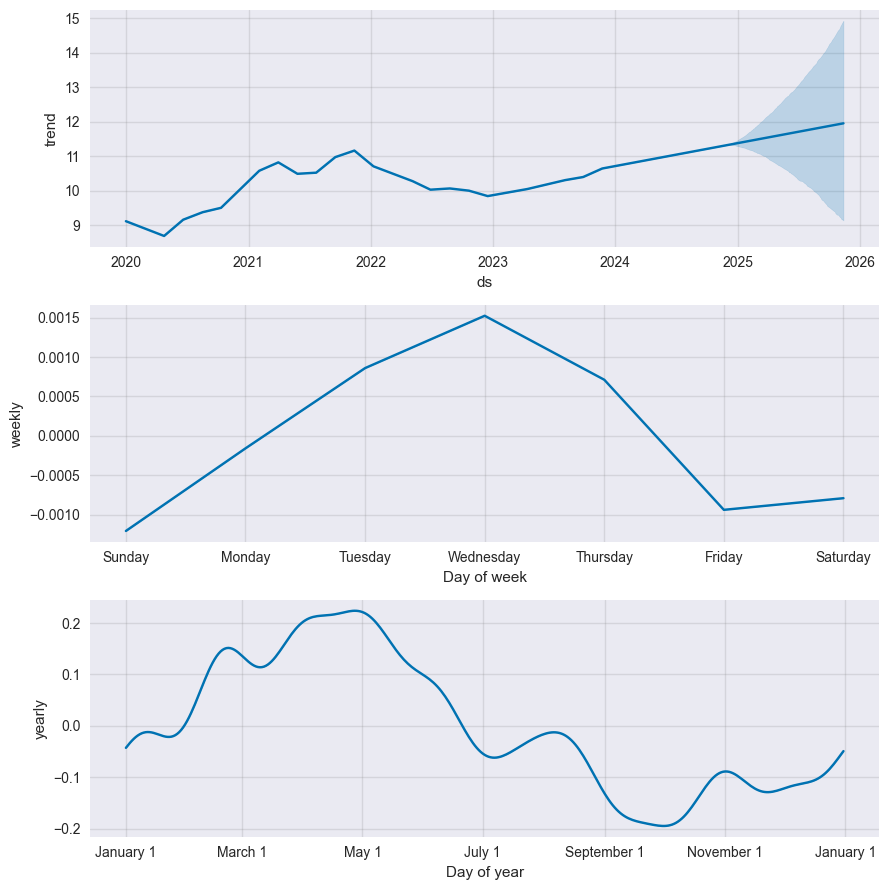

In [51]:
fig2 = m_baseline.plot_components(forecast_baseline_full)
plt.show()

**Interpretation (qualitative)**  

From the components plot, we see how Prophet decomposes the log-price of Bitcoin into a smooth trend plus weekly and yearly seasonalities:

- **Trend component (`g(t`)**:  
  The trend captures the long-term growth of Bitcoin’s log-price, with clear regime changes. It rises strongly from 2020 to late 2021, then flattens / corrects around 2022 before resuming a more moderate upward slope afterwards. The forecast part shows a continuation of this upward trajectory, but with very wide uncertainty bands, reflecting the intrinsic volatility and unpredictability of Bitcoin.

- **Weekly seasonality (`s_weekly(t`)**:  
  The weekly pattern has a very small amplitude compared with the trend. Prices tend to be slightly higher in the middle of the week (around Wednesday) and slightly lower over the weekend, but the effect is weak. This suggests that day-of-week behaviour exists but is minor relative to the large structural moves of the market.

- **Yearly seasonality (`s_yearly(t`)**:  
  The yearly component shows more favourable log-returns from roughly January to late spring, a dip around summer / early autumn, and a mild recovery towards the end of the year. This can be interpreted as a loose “cycle” in Bitcoin activity. However, as for the weekly pattern, the magnitude of this yearly seasonality remains small compared to major bull and bear phases.

Overall, the **trend clearly dominates** the decomposition, while weekly and yearly seasonalities provide only **weak corrections**, which is consistent with the behaviour of Bitcoin: a highly volatile asset where large structural shocks matter much more than regular calendar effects.


### 5.2 Residual analysis (on training period)

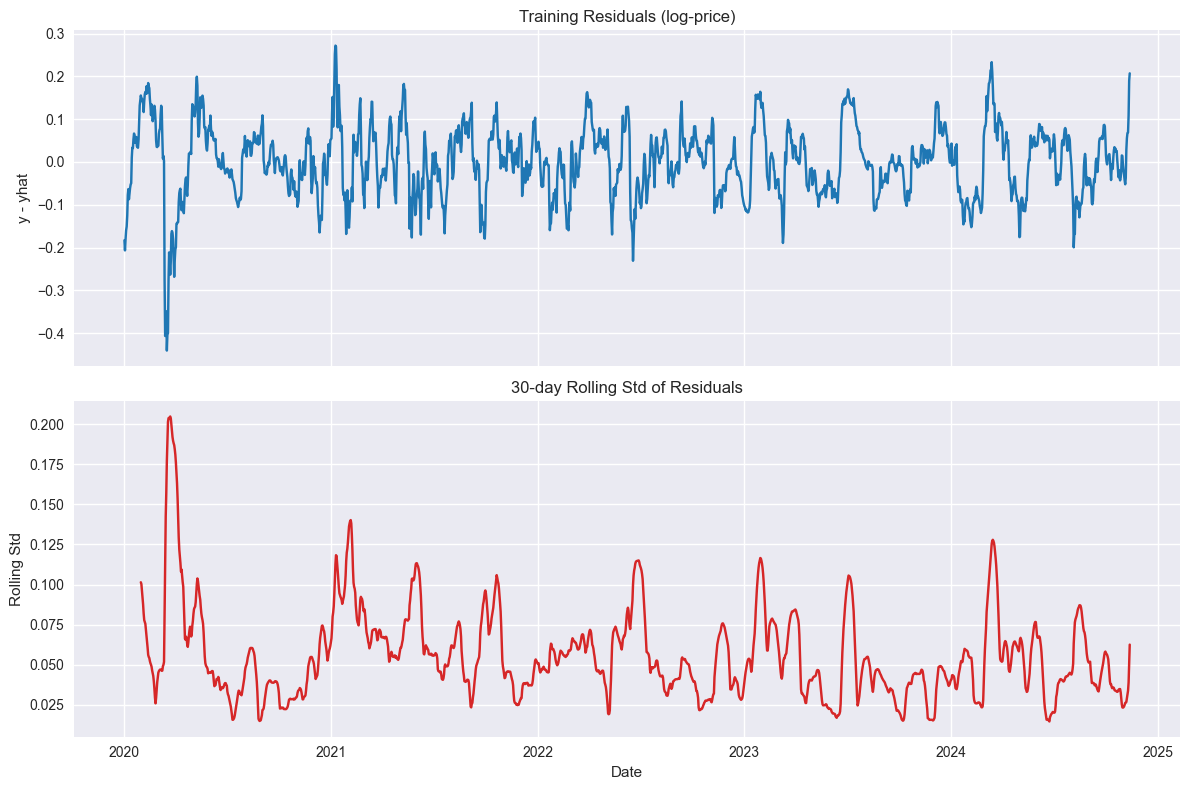

In [52]:
# Extract only training period from merged DataFrame
df_train_pred = df_all_baseline[df_all_baseline["ds"] <= cutoff_date].copy()

# Residuals in log-price space
df_train_pred["residual_log"] = df_train_pred["y"] - df_train_pred["yhat"]

# Rolling std of residuals to visualize volatility of errors
resid_window = 30
df_train_pred["resid_rolling_std"] = df_train_pred["residual_log"].rolling(
    window=resid_window
).std()

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axes[0].plot(df_train_pred["ds"], df_train_pred["residual_log"], color="tab:blue")
axes[0].set_title("Training Residuals (log-price)")
axes[0].set_ylabel("y - yhat")
axes[0].grid(True)

axes[1].plot(df_train_pred["ds"], df_train_pred["resid_rolling_std"], color="tab:red")
axes[1].set_title(f"{resid_window}-day Rolling Std of Residuals")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Rolling Std")
axes[1].grid(True)

plt.tight_layout()
plt.show()

**Comment on residuals and volatility:**

- Residuals still exhibit periods of **higher** and **lower** variance.
- This reflects the fact that Prophet focuses on modeling the **conditional mean** (trend + seasonality).
- **Heteroskedasticity** (time-varying volatility) remains in the error term \( \varepsilon_t \).

To explicitly model volatility, one would typically use **GARCH-type models** on returns.  
Here, Prophet and GARCH would be **complementary**: Prophet for the expected level, GARCH for volatility.


---

## 6. Forecast accuracy: MAE, RMSE, MAPE on the test set

We now evaluate the **baseline Prophet model** on the **held-out test set**:

- MAE  – Mean Absolute Error (same units as the price).
- RMSE – Root Mean Squared Error (penalizes large errors).
- MAPE – Mean Absolute Percentage Error (relative error in %).


### 6.1 Compute metrics on the test set (baseline model)

In [53]:


def compute_metrics(df_all, cutoff):
    """
    Compute MAE, RMSE, MAPE on the test period (ds > cutoff),
    using price-level actuals and predictions.
    """
    df_test = df_all[df_all["ds"] > cutoff].copy()
    
    y_true = df_test["y_actual_price"].values
    y_pred = df_test["yhat_price"].values
    
    # Avoid division by zero in MAPE
    mask = y_true != 0
    y_true_safe = y_true[mask]
    y_pred_safe = y_pred[mask]
    
    mae = mean_absolute_error(y_true_safe, y_pred_safe)
    rmse = np.sqrt(mean_squared_error(y_true_safe, y_pred_safe))
    mape = np.mean(np.abs((y_true_safe - y_pred_safe) / y_true_safe)) * 100
    
    return mae, rmse, mape

mae_base, rmse_base, mape_base = compute_metrics(df_all_baseline, cutoff_date)

print("=== Baseline Prophet Model: Test Set Performance ===")
print(f"MAE  (USD): {mae_base:,.2f}")
print(f"RMSE (USD): {rmse_base:,.2f}")
print(f"MAPE (%):   {mape_base:,.2f}")


=== Baseline Prophet Model: Test Set Performance ===
MAE  (USD): 18,634.21
RMSE (USD): 22,567.22
MAPE (%):   19.39


### 6.2 Short discussion

For the **baseline Prophet model** evaluated on the held-out test set, we obtain:

- **MAE  ≈ 18,634 USD**
- **RMSE ≈ 22,567 USD**
- **MAPE ≈ 19.4%**

**How to read these numbers:**

- **MAE (18.6k USD)**  
  On average, the forecast is about **18,600 USD away** from the true daily Bitcoin price on the test period.  
  Given that BTC often trades in the 50–70k USD range, this corresponds to a sizeable but not catastrophic absolute error.

- **RMSE (22.6k USD)**  
  The RMSE is clearly **larger than the MAE** (22.6k vs 18.6k), which means the model makes a few **very large mistakes**.  
  These big errors typically occur around **sharp trend reversals or explosive rallies/crashes**, when the price moves faster than the smooth Prophet trend can adapt.

- **MAPE (19.4%)**  
  On average, the predicted price is about **19–20% away** from the actual price.  
  For a highly volatile asset like Bitcoin, a ~19.50% MAPE indicates that Prophet captures the **overall level and direction** reasonably well, but still struggles to be very precise during extreme market moves.

**Link with residuals & volatility:**

- The residual and rolling-volatility plots show clear **heteroskedasticity**: periods of calm with low residual variance, and bursts of very high volatility.
- This is consistent with the metrics above:  
  Prophet is primarily a model for the **conditional mean** (trend + seasonality). It does **not** explicitly model volatility, so sudden regime changes generate the large errors that inflate RMSE and MAPE.
- In practice, a more advanced approach would combine **Prophet for the expected price level** with a **GARCH-type model on returns** to capture time-varying volatility.  
  Our results illustrate that Prophet alone is a good baseline for the level of BTC prices, but not sufficient to fully describe their extreme variability.


---

## 7. Improved Prophet model for Bitcoin (multiplicative + changepoints)

We now build a slightly more advanced Prophet model that is more aligned with the theory and Bitcoin’s behaviour:

- **Seasonality mode**: `"multiplicative"`  
  (amplitude grows with the level of the series, which is realistic for BTC).
- **Changepoint prior scale**: tuned (e.g. 0.1)  
  to allow somewhat more flexibility in the trend without overfitting.

We train on the **same training set** and compare metrics with the baseline model.


### 7.1 Improved model definition and training

In [54]:
m_improved = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    seasonality_mode="multiplicative",   # better when seasonal amplitude scales with price level
    changepoint_prior_scale=0.1          # allows more flexible trend than default 0.05
)

m_improved.fit(train)

11:29:10 - cmdstanpy - INFO - Chain [1] start processing
11:29:11 - cmdstanpy - INFO - Chain [1] done processing


### 7.2 Forecast and metrics for the improved model

In [63]:
future_improved = m_improved.make_future_dataframe(
    periods=len(test),
    freq="D"
)

# Full forecast (ds, yhat, trend, components, etc.)
forecast_improved_full = m_improved.predict(future_improved)

# Lighter version for metrics / tables
forecast_improved = forecast_improved_full[["ds", "yhat", "yhat_lower", "yhat_upper"]].copy()

df_all_improved = prepare_forecast_df(df_prophet, forecast_improved)

mae_imp, rmse_imp, mape_imp = compute_metrics(df_all_improved, cutoff_date)

print("=== Improved Prophet Model: Test Set Performance ===")
print(f"MAE  (USD): {mae_imp:,.2f}")
print(f"RMSE (USD): {rmse_imp:,.2f}")
print(f"MAPE (%):   {mape_imp:,.2f}")

=== Improved Prophet Model: Test Set Performance ===
MAE  (USD): 19,754.83
RMSE (USD): 24,306.44
MAPE (%):   20.59


#### Comparison table: baseline vs improved

In [64]:
metrics_comparison = pd.DataFrame(
    {
        "Baseline (additive)": {
            "MAE (USD)": mae_base,
            "RMSE (USD)": rmse_base,
            "MAPE (%)": mape_base,
        },
        "Improved (multiplicative)": {
            "MAE (USD)": mae_imp,
            "RMSE (USD)": rmse_imp,
            "MAPE (%)": mape_imp,
        },
    }
).T

display(metrics_comparison)


,MAE (USD),RMSE (USD),MAPE (%)
Baseline (additive),18634.205543,22567.215006,19.394372
Improved (multiplicative),19754.826566,24306.441175,20.587364


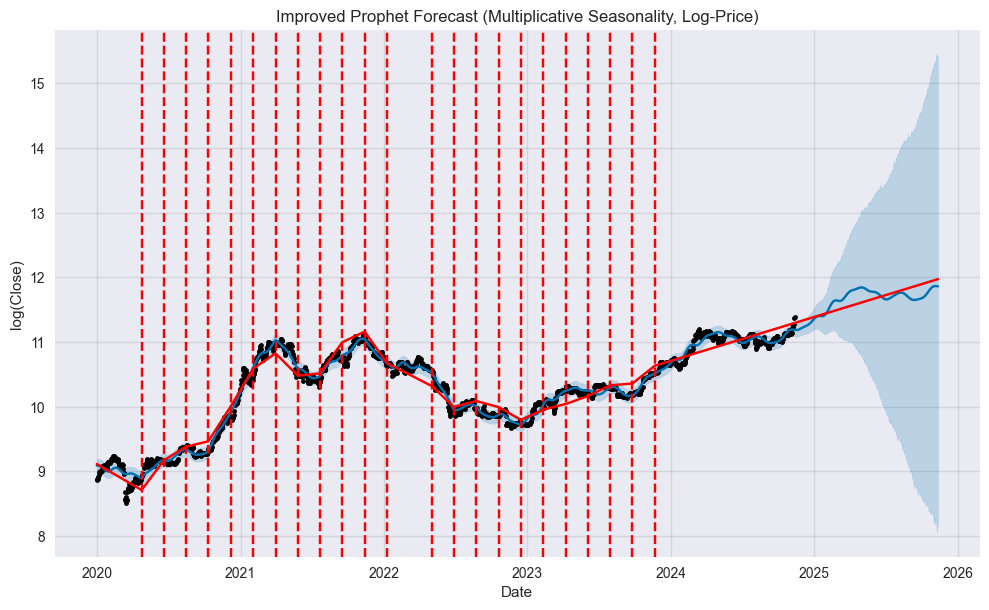

In [66]:
fig3 = m_improved.plot(forecast_improved_full)
plt.title("Improved Prophet Forecast (Multiplicative Seasonality, Log-Price)")
plt.xlabel("Date")
plt.ylabel("log(Close)")
plt.grid(True)

_ = add_changepoints_to_plot(fig3.gca(), m_improved, forecast_improved_full)
plt.show()


### 7.3 Interpretation

From the comparison table above:

- The **baseline additive model** achieves  
  MAE ≈ 18.6k USD, RMSE ≈ 22.6k USD, MAPE ≈ 19.4%.
- The **improved multiplicative model** is **slightly worse** on all three metrics  
  (MAE ≈ 19.8k USD, RMSE ≈ 24.3k USD, MAPE ≈ 20.6%).

This means that, on our test period, the additional flexibility
(multiplicative seasonality + higher `changepoint_prior_scale`) **does not improve
out-of-sample accuracy**. In other words, the more “theoretically realistic”
specification does not automatically translate into better forecasts.

Possible explanations are:

- We already work on the **log-price**, so an additive model on `log(Close)`
behaves similarly to a multiplicative model on the original price –
the gain from switching to `seasonality_mode="multiplicative"` is therefore limited.
- Increasing `changepoint_prior_scale` makes the trend more flexible, which can
fit some in-sample moves better but also increases the risk of **overfitting**,
leading to slightly larger errors on the test set.
- For a highly noisy asset like Bitcoin, simple smooth trends can sometimes be
as effective as more complex specifications.

In practice, given these results, we would **keep the baseline additive model**
as our main Prophet specification for BTC in this project, and treat the
multiplicative model as an interesting sensitivity check rather than a clear
improvement.


---

## 8. Time-based cross-validation with Prophet

Prophet provides built-in tools to perform **rolling-origin time-series cross-validation**:

- We repeatedly:
  1. Train the model up to a certain cutoff.
  2. Forecast for a given horizon (e.g. 60 or 90 days).
  3. Compare predictions to actuals.

This better simulates **real forecasting performance over time**, rather than relying on a single train/test split.


### 8.1 Cross-validation on the improved model

In [69]:
from prophet.diagnostics import cross_validation

n_train = len(train)
n_test = len(test)

# We want a 1-year ahead forecast in CV, like our final test evaluation
horizon_days = min(365, n_test)

# Step between cutoffs: ~4 months
period_days = 120

# Maximum initial window that still leaves at least horizon + period after it
max_initial = n_train - horizon_days - period_days

# Try to use ~3 years if possible, otherwise fall back to the max allowed
initial_days = min(1095, max_initial)  # 1095 ≈ 3 years

print(f"initial  = {initial_days} days")
print(f"period   = {period_days} days")
print(f"horizon  = {horizon_days} days")

df_cv = cross_validation(
    m_improved,
    initial=f"{initial_days} days",
    period=f"{period_days} days",
    horizon=f"{horizon_days} days",
    parallel="processes"   # <- FIX: was "auto"
)

display(df_cv.head())


initial  = 1095 days
period   = 120 days
horizon  = 365 days


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2023-03-19,10.055133,9.971817,10.129960,10.232635,2023-03-18
1,2023-03-20,10.057608,9.988176,10.139716,10.234443,2023-03-18
2,2023-03-21,10.060714,9.979492,10.140467,10.240615,2023-03-18
3,2023-03-22,10.065415,9.980777,10.150046,10.226425,2023-03-18
4,2023-03-23,10.066554,9.987413,10.141042,10.242898,2023-03-18


In [70]:
from prophet.diagnostics import performance_metrics
df_pm = performance_metrics(df_cv)
display(df_pm.head())


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,0.061168,0.247322,0.205217,0.019912,0.017514,0.019792,0.244648
1,38 days,0.064158,0.253295,0.210560,0.020434,0.017567,0.020302,0.235474
2,39 days,0.067220,0.259268,0.215910,0.020957,0.017843,0.020813,0.232416
3,40 days,0.070418,0.265365,0.221429,0.021497,0.018122,0.021341,0.232416
4,41 days,0.073549,0.271199,0.226630,0.022006,0.018408,0.021839,0.232416


### 8.3 Plot MAE, RMSE, and MAPE as a function of forecast horizon

#### RMSE vs horizon

c:\Users\leoje\Desktop\Prophet_Project\.venv\Lib\site-packages\prophet\plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
c:\Users\leoje\Desktop\Prophet_Project\.venv\Lib\site-packages\prophet\plot.py:548: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


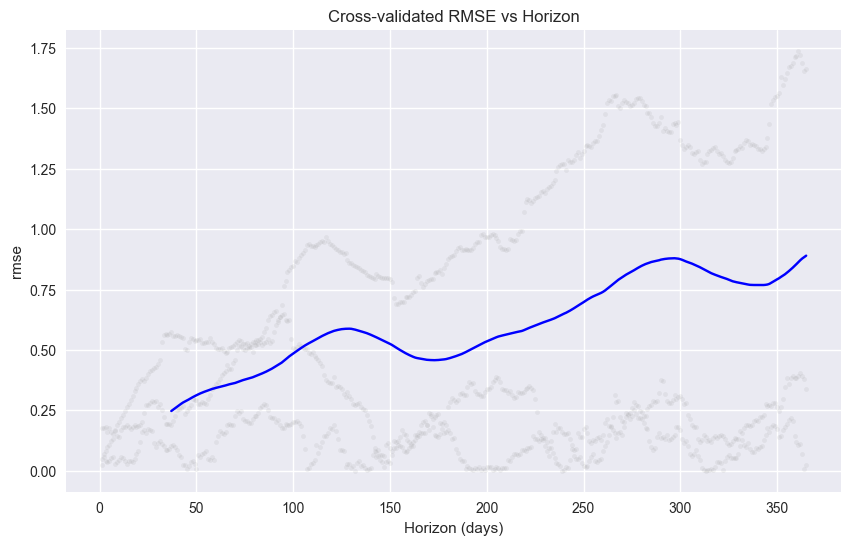

In [71]:
_ = plot_cross_validation_metric(df_cv, metric="rmse")
plt.title("Cross-validated RMSE vs Horizon")
plt.show()

#### MAE vs horizon

c:\Users\leoje\Desktop\Prophet_Project\.venv\Lib\site-packages\prophet\plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
c:\Users\leoje\Desktop\Prophet_Project\.venv\Lib\site-packages\prophet\plot.py:548: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


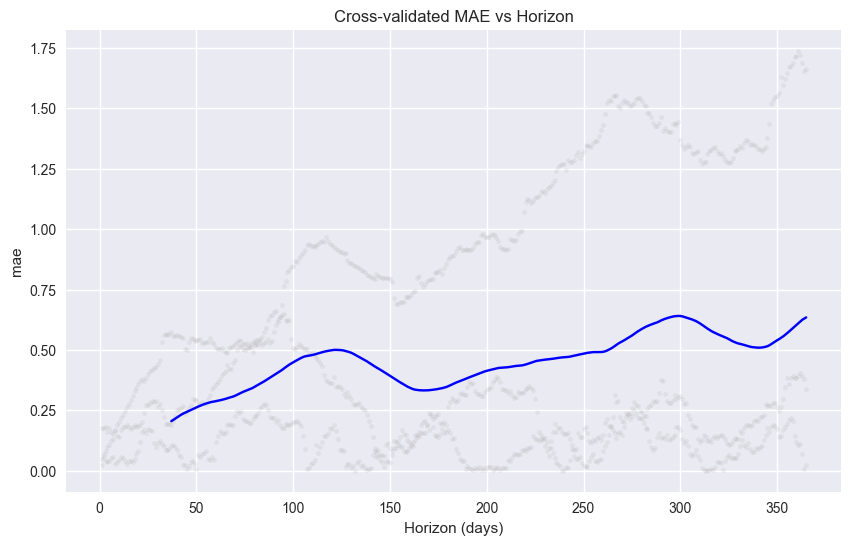

In [72]:
_ = plot_cross_validation_metric(df_cv, metric="mae")
plt.title("Cross-validated MAE vs Horizon")
plt.show()

#### MAPE vs horizon

c:\Users\leoje\Desktop\Prophet_Project\.venv\Lib\site-packages\prophet\plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
c:\Users\leoje\Desktop\Prophet_Project\.venv\Lib\site-packages\prophet\plot.py:548: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


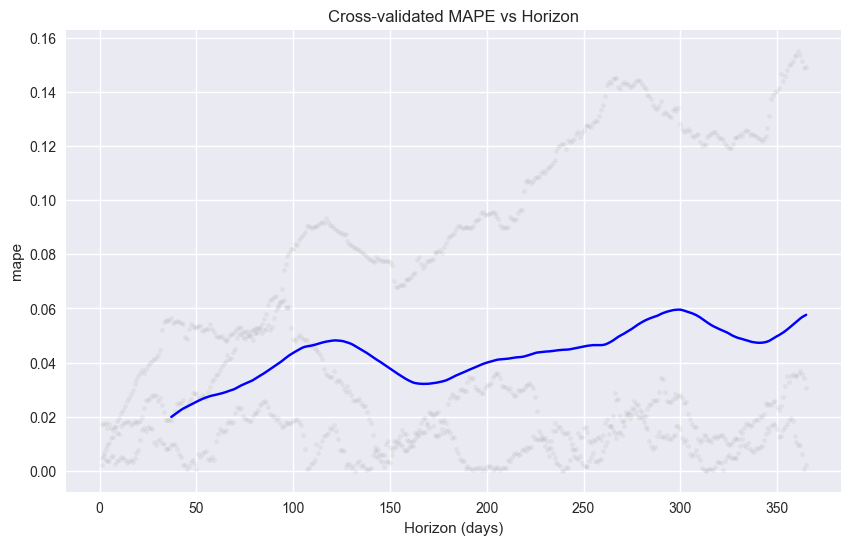

In [73]:
_ = plot_cross_validation_metric(df_cv, metric="mape")
plt.title("Cross-validated MAPE vs Horizon")
plt.show()

**Interpretation:**

- On these cross-validation plots, **errors (MAE, RMSE, MAPE) stay relatively low for short horizons (≈ 1–2 months)**, then **increase as the forecast horizon grows**:
  - Between ~40 and ~120 days, errors rise steadily: short-term forecasts are clearly more accurate.
  - Around **150–180 days**, we observe a small **dip** in the error curves: mid-term horizons (about 5–6 months) are slightly easier to predict for this dataset.
  - Beyond ~200 days, errors **increase again up to 1 year**, and the model becomes significantly less accurate, which is expected for such a volatile asset.

- Cross-validation gives a **distribution of errors over many rolling forecast windows**, instead of just one train/test split.  
  It shows that the model is **robust on short horizons**, but that uncertainty and forecast error **grow as we move toward longer horizons**.

This behaviour is consistent with Prophet’s theoretical use case: it works best for **short to medium-term horizons (weeks to a few months)**. For **very long-term forecasts (close to one year) on a highly volatile series like Bitcoin**, errors naturally become larger, and results should be interpreted with caution.


# 9. Final conclusion (link with theory)

We now connect our practical results with the theoretical structure of Prophet:

\[
y(t) = g(t) + s(t) + h(t) + \varepsilon_t
\]

- \( g(t) \) – Trend:
  - Modeled as a **piecewise linear** function with **automatic changepoints**.
  - On Bitcoin, this clearly picked up the main regime shifts: the strong bull run of 2020–2021, the correction in 2022, and the renewed upward phase afterwards.
  - We tested:
    - A **baseline additive** model with default trend flexibility.
    - A more flexible **multiplicative** model with `changepoint_prior_scale = 0.1`.
  - On the **test set (≈ 1 year ahead)**, the baseline model reached  
    **MAE ≈ 18.6k USD, RMSE ≈ 22.6k USD, MAPE ≈ 19.4%**,  
    while the multiplicative model gave slightly **higher errors**.  
    This shows that increasing trend flexibility does not automatically improve
    out-of-sample performance and can introduce a bit of overfitting.

- \( s(t) \) – Seasonality:
  - Modeled via **Fourier series** in Prophet.
  - We included **weekly** and **yearly** seasonality.
  - For BTC, the components plot showed:
    - A **small weekly pattern** (slightly higher mid-week, slightly lower on weekends).
    - A **moderate yearly pattern** with better performance in the first half of the year and a dip around summer/autumn.
  - These effects exist but remain **weak compared with the dominant trend** and regime changes, which is coherent with the idea that Bitcoin behaves less like a regular “business time series”.

- \( h(t) \) – Holidays / Events:
  - Not explicitly used in this notebook, although Prophet supports it.
  - In a richer model we could add:
    - **Bitcoin halving dates**, major regulatory announcements, ETF approvals, etc.
  - These event terms would allow us to test whether specific crypto events systematically shift the price level around known dates.

- \( \varepsilon_t \) – Error term:
  - Contains residual noise and unmodelled structure, especially **volatility**.
  - Our residual + rolling-volatility plots showed clear **heteroskedasticity**:
    clusters of calm periods and bursts of very high variance.
  - Prophet’s assumption of roughly i.i.d. Gaussian errors is therefore **only an approximation** for BTC, which helps explain the wide prediction intervals on long horizons.

---

### Handling non-stationarity

Bitcoin’s price series is **strongly non-stationary**:

- Long bull and bear markets, bubbles, and crashes.
- Classical ARIMA-type models would require differencing the series and working on returns.

Our workflow made this manageable by:

- Fitting Prophet on **log-prices** instead of raw prices, which stabilizes growth and makes the additive decomposition more realistic.
- Using a **trend with changepoints**, which naturally adapts to structural breaks.
- Showing that a very flexible trend (higher `changepoint_prior_scale`) did **not** improve test performance, which illustrates the usual bias–variance trade-off on non-stationary financial data.

---

### Volatility and limitations

Prophet does **not** directly model volatility:

- Time-varying volatility (heteroskedasticity) stays in \( \varepsilon_t \), as confirmed by the rolling standard deviation of residuals.
- Our 1-year ahead test forecast remained **reasonably accurate on average** (MAPE ≈ 19%), but still produced **large errors around sharp reversals**, which is typical on crypto markets.

In a more advanced setting, one could:

- Apply Prophet to the **expected price level** (trend + seasonality).
- Fit a **GARCH-type model** on returns to capture volatility clustering.
- Combine both to obtain forecasts for **both level and risk**.

**Strengths of Prophet for BTC-USD in this project:**

- Clear, interpretable decomposition into trend + seasonality.
- Automatic **changepoint detection** that matches visual regime shifts.
- Ability to handle missing data and provide **uncertainty intervals**.
- Good behaviour on **short and medium horizons**, as confirmed by cross-validation:
  - Cross-validated MAE/RMSE/MAPE are low for horizons up to a few months,
  - and increase progressively as we approach a full year.

**Limitations:**

- For a highly volatile asset, prediction intervals become **very wide** on long horizons.
- The model struggles to anticipate **sudden crashes or parabolic rallies**.
- It does not explicitly model **autocorrelation of returns** or **volatility clustering**.

---

### Comparison with SARIMAX/GARCH (conceptually)

- **SARIMAX / ARIMA-type models**:
  - Typically applied to **stationarized returns**.
  - Capture the short-term autocorrelation structure well.
  - Combined with **GARCH**, they can explicitly model and forecast **volatility**.

- **Prophet**:
  - Works directly on **(log-)prices** without manual differencing.
  - Focuses on a **structural decomposition** (trend, seasonality, events) that is easy to interpret.
  - Particularly convenient for explaining **medium-term dynamics** and incorporating known calendar or event effects.

In a comprehensive Bitcoin forecasting framework, a practitioner could:

- Use **Prophet** to understand and forecast the **expected price path** and its main regimes.
- Use **GARCH-family models** to forecast **volatility and risk**.
- Compare or combine the two approaches to obtain a more complete view of the BTC market.

---

Overall, this notebook delivers a complete Prophet-based workflow for **Bitcoin price forecasting**: from data preparation and model specification to diagnostics, cross-validation, and critical discussion of limitations. The results are consistent with Prophet theory and form a solid, interpretable project for a 2nd-year AI/Data student.
